Use this notebook to check if all the modules are working independently

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import importlib

import astropy
import astropy.units as u
import astropy.constants as c
from astropy.cosmology import default_cosmology

In [2]:
# Plot Styling
plt.style.use('dark_background')
plt.rcParams.update({
    'font.family':'serif', 'mathtext.fontset':'dejavuserif',
    'axes.grid':True, 'grid.linestyle': ':', 'grid.alpha': 0.5,
    'xtick.direction':'in', 'xtick.minor.visible': True, 'xtick.top':True,
    'ytick.direction':'in', 'ytick.minor.visible': True, 'ytick.right':True,
    'figure.figsize': [9, 6], 'axes.titlesize':30, 'legend.fontsize': 15, 'legend.title_fontsize': 20,
    'axes.labelsize':25, 'xtick.labelsize':15, 'ytick.labelsize':15
})

# Halo Profiles (one-halo)

Density and Pressure profiles are the crux of the forward model, containing the baryonic astrophysics we'd want to examine.

In [3]:
# Arrays chosen arbitrarily here
logmshalo = np.linspace(11, 14, 50)
zs = np.linspace(0.4, 1.1, 10)
rs = np.logspace(-1.5, 1.5, 100)

# The GNFW profile model also needs cosmological parameters
cpars = {"hh": 0.7, "Omega_L":0.75, "Omega_m":0.25, "Omega_b": 0.044, "XH": 0.76, "T_CMB":2.725}

# Profiles require R200c and rho_crit, which can be outside functions from anywhere
cosmology = astropy.cosmology.LambdaCDM(H0=cpars["hh"]*100, Tcmb0=cpars["T_CMB"], Om0=cpars["Omega_m"], Ode0=cpars["Omega_L"], Ob0=cpars["Omega_b"])
rhoc = lambda zs: cosmology.critical_density(zs).to(u.Msun/u.Mpc**3).value
r200c = lambda zs, logmshalo: (10**logmshalo/(4/3*np.pi*200*rhoc(zs)[:, None]))**(1/3)

# We precompute values that wouldn't change with any of our fit parameters
rs200c = r200c(zs, logmshalo)
rhocs = rhoc(zs)

In [4]:
import Models.Profiles as Profiles
importlib.reload(Profiles)

# Call the general model
Battaglia12 = Profiles.Battaglia2012({'model':'B12'})
# Call the function with all its setup inputs, which will return a function only dependent on fit parameters
Battaglia12_1h = Battaglia12.Pth1h(rs, zs, logmshalo, rhocs, rs200c, **cpars)
# Calling the functions with no parameters inputs will default to the fiducial parameters

Battaglia15 = Profiles.Battaglia2015({'model':'AGN'})
Battaglia15_1h = Battaglia15.rho1h(rs, zs, logmshalo, rhocs, rs200c, **cpars)

Amodeo = Profiles.Amodeo2021({'model':'GNFW'})
AmodeoPth_1h = Amodeo.Pth1h(rs, zs, logmshalo, rhocs, rs200c, **cpars)
Amodeorho_1h = Amodeo.rho1h(rs, zs, logmshalo, rhocs, rs200c, **cpars)

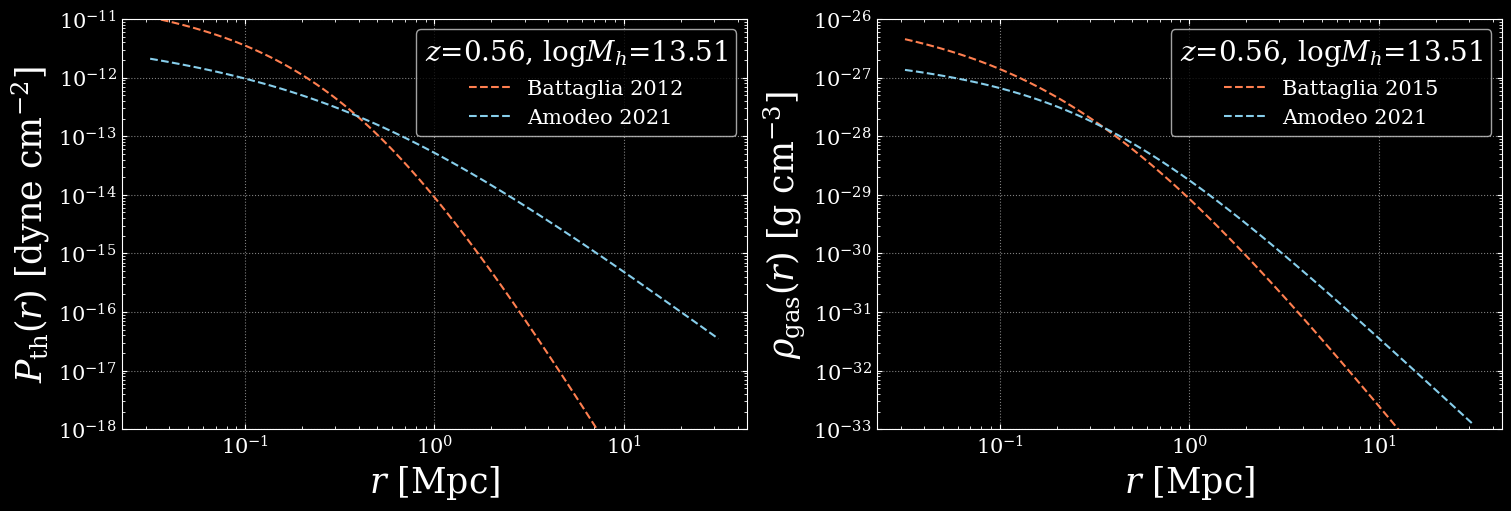

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), layout='constrained')

zindex, mindex = 2, 41

axs[0].loglog(rs, Battaglia12_1h()[:, zindex, mindex], ls='--', c='coral', label=f'Battaglia 2012')
axs[1].loglog(rs, Battaglia15_1h()[:, zindex, mindex], ls='--', c='coral', label='Battaglia 2015')

axs[0].loglog(rs, AmodeoPth_1h()[:, zindex, mindex], ls='--', c='skyblue', label='Amodeo 2021')
axs[1].loglog(rs, Amodeorho_1h()[:, zindex, mindex], c='skyblue', ls='--', label='Amodeo 2021')

axs[0].set(ylabel=r'$P_\text{th}(r)$ [dyne cm$^{-2}$]', xlabel=r'$r$ [Mpc]', ylim=(1e-18, 1e-11)); axs[0].legend(title=f'$z$={zs[zindex]:.2f}, log$M_h$={logmshalo[mindex]:.2f}')
axs[1].set(ylabel=r'$\rho_\text{gas}(r)$ [g cm$^{-3}]$', xlabel=r'$r$ [Mpc]', ylim=(1e-33, 1e-26)); axs[1].legend(title=f'$z$={zs[zindex]:.2f}, log$M_h$={logmshalo[mindex]:.2f}')

plt.show()

# Stellar Mass Functions & Redshift Distributions

Sample-averaged halo profiles can be calculated with a weighted average using the sample's Stellar Mass Function. SMFs are also used to calculate mean/median mass and redshift values, and inform mass integration limits when calculating cross-spectra. 

In [211]:
# Cosmological parameters are used for conversions and volume calculations
cpars = {"hh": 0.7, "Omega_L":0.7, "Omega_m":0.3, "Omega_b": 0.044, "XH": 0.76, "T_CMB":2.725}

In [ ]:
import Models.SMFs as SMFs
importlib.reload(SMFs)

# Load the model
desi1p = SMFs.DESI1Percent({'sample':'LRG'})
# Calculate the average stellar mass function over all redshifts
desi1p_smf = desi1p.dndlogmstar(**cpars)
# Get the redshift distribution by dividing by the area
desi1p_zdist = desi1p.N_z(**cpars)/desi1p.info['area']

desiXcorr = SMFs.DESILRGsCrossCorr({'pzbin':'all', 'hemisphere':'combined','sample':'main'})
desiXcorr_zdist = desiXcorr.N_z(**cpars)/desiXcorr.info['area']

# This one will take time as it's loading in an entire galaxy catalog
# cmass = SMFs.BOSSDR10({'galaxy':'CMASS','group':'portsmouth', 'template':'passive', 'IMF':'Kroupa'})
cmass.make_SMF(**cpars)
cmass_smf = cmass.dndlogmstar(**cpars)
cmass_zdist = cmass.N_z(**cpars)/cmass.info['area']

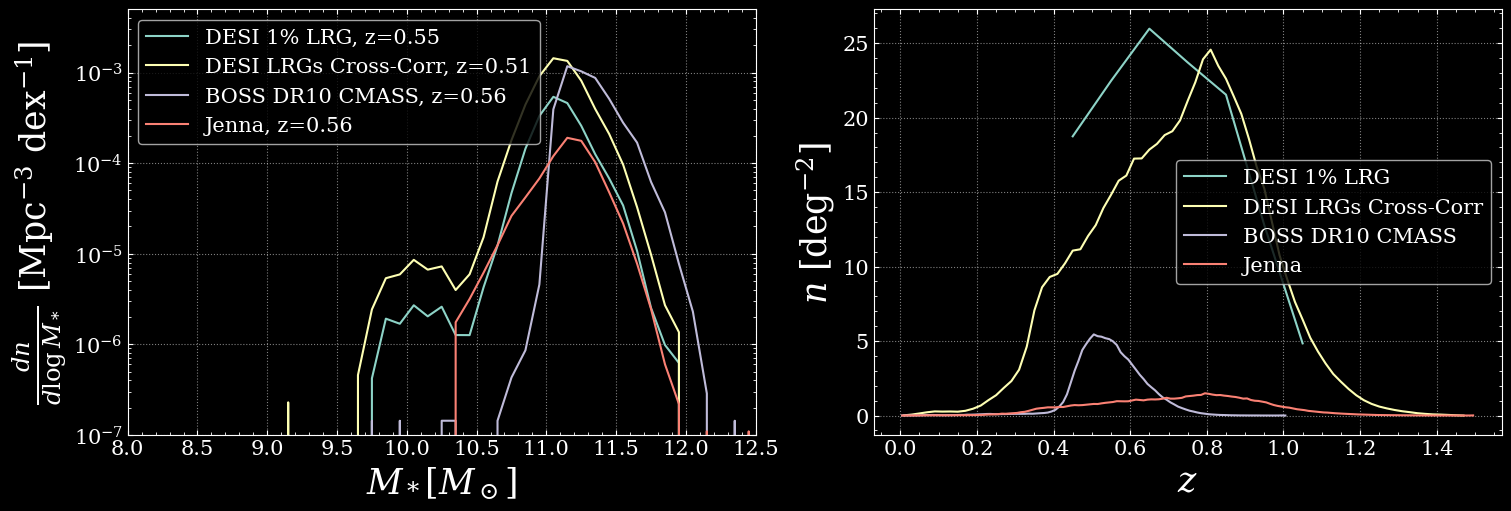

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), layout='constrained')

zindex = 1
axs[0].plot(desi1p.logmstar, desi1p_smf[zindex], label=f'DESI 1% LRG, z={desi1p.z[zindex]:.2f}')
axs[1].plot(desi1p.z, desi1p_zdist, label=f'DESI 1% LRG')

zindex=25
axs[0].plot(desiXcorr.logmstar, desiXcorr.dndlogmstar(**cpars)[zindex], label=f'DESI LRGs Cross-Corr, z={desiXcorr.z[zindex]:.2f}')
axs[1].plot(desiXcorr.z, desiXcorr_zdist, label=f'DESI LRGs Cross-Corr')

zindex = 55
axs[0].plot(cmass.logmstar, cmass_smf[zindex], label=f'BOSS DR10 CMASS, z={cmass.z[zindex]:.2f}')
axs[1].plot(cmass.z, cmass_zdist, label='BOSS DR10 CMASS')

axs[0].set(xlabel=r'$M_* [M_\odot]$', ylabel=r'$\frac{dn}{d\log M_*}$ [Mpc$^{-3}$ dex$^{-1}$]', yscale='log', xlim=(8, 12.5), ylim=(1e-7, 5e-3)); axs[0].legend()
axs[1].set(xlabel=r'$z$', ylabel=r'$n$ [deg$^{-2}$]'); axs[1].legend()
plt.show()

# Stellar-Halo Mass Relations

If you're using a Stellar Mass Function (SMF) in a weighted average to calculate sample-average halo profiles or to inform the bounds of the mass range of your sample, you need to use a SHMR to convert the solar mass units of the SMF to halo mass units that most profile models use. 

In [9]:
logmhalo = np.linspace(10, 15, 100)
logmstar = np.linspace(8, 12, 100)

In [10]:
import Models.SHMRs as SHMRs

# Load in the model
DR7CMASS = SHMRs.Xu2023({'sample':'CMASS_BP13'})
# Give an input mass array to be converting
logmstar_DR7CMASS = DR7CMASS.HSMR(logmhalo)
logmhalo_DR7CMASS = DR7CMASS.SHMR(logmstar)

DESI1P = SHMRs.Gao2023({'sample': 'ELG_Auto'})
logmstar_DESI1P = DESI1P.HSMR(logmhalo)
logmhalo_DESI1P = DESI1P.SHMR(logmstar)

SDSSDR8 = SHMRs.Kravstov2014({'sample':'Mvir_scatter'})
logmstar_SDSSDR8 = SDSSDR8.HSMR(logmhalo)
logmhalo_SDSSDR8 = SDSSDR8.SHMR(logmstar)

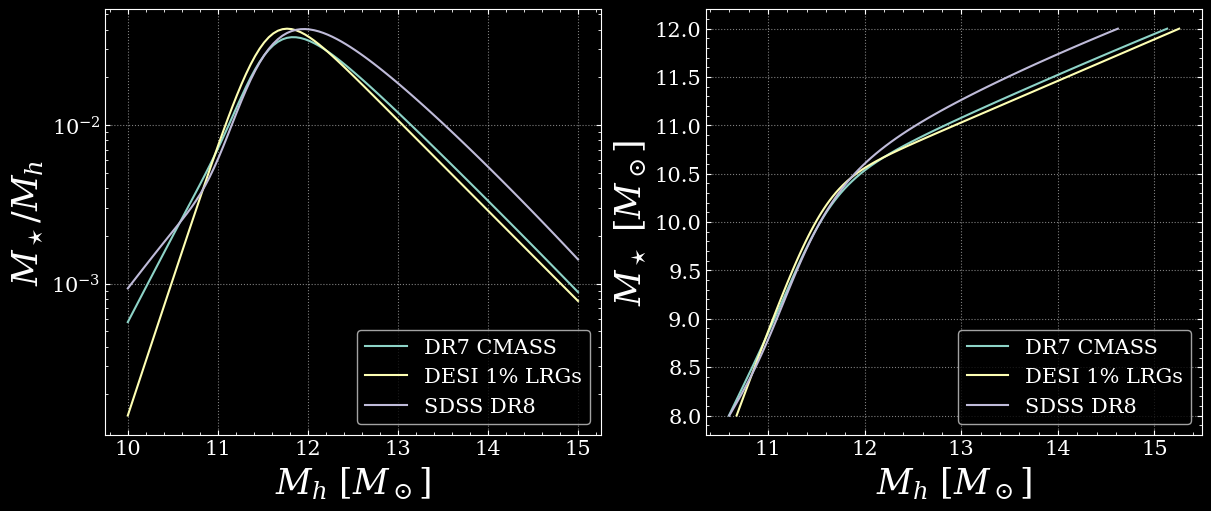

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), layout='constrained')

axs[0].plot(logmhalo, 10**logmstar_DR7CMASS()/10**logmhalo, label='DR7 CMASS')
axs[1].plot(logmhalo_DR7CMASS(), logmstar, label='DR7 CMASS')

axs[0].plot(logmhalo, 10**logmstar_DESI1P()/10**logmhalo, label='DESI 1% LRGs')
axs[1].plot(logmhalo_DESI1P(), logmstar, label='DESI 1% LRGs')

axs[0].plot(logmhalo, 10**logmstar_SDSSDR8()/10**logmhalo, label='SDSS DR8')
axs[1].plot(logmhalo_SDSSDR8(), logmstar, label='SDSS DR8')

axs[0].set(xlabel=r'$M_h \ [M_\odot]$', ylabel=r'$M_\star / M_h$', yscale='log'); axs[0].legend()
axs[1].set(xlabel=r'$M_h \ [M_\odot]$', ylabel=r'$M_\star \ [M_\odot]$'); axs[1].legend()

plt.show()

# Halo Occupancy Distributions

If you're calculating sample-averaged profiles through the galaxy-$y$ cross-spectra, you need an HOD which describes the average number of central/satellite galaxies as a function of halo mass.

In [12]:
logmhalo = np.linspace(10, 15, 100)

In [13]:
import Models.HODs as HODs
importlib.reload(HODs)

Kou = HODs.Kou2023({'sample':'M*>10.8'})
KouNc = Kou.Nc(logmhalo)
KouNs = Kou.Ns(logmhalo)

Yuan = HODs.Yuan2023({'sample':"LRG 0.4<z<0.6"})
YuanNc = Yuan.Nc(logmhalo)
YuanNs = Yuan.Ns(logmhalo)

Linke = HODs.Linke2022({'sample':'MS red'})
LinkeNc = Linke.Nc(logmhalo)
LinkeNs = Linke.Ns(logmhalo)

Kusiak = HODs.Kusiak2022({'sample':'Red'})
KusiakNc = Kusiak.Nc(logmhalo)
KusiakNs = Kusiak.Ns(logmhalo)

More = HODs.More2015({'sample':'[11.10, 12.00]'})
MoreNc = More.Nc(logmhalo)
MoreNs = More.Ns(logmhalo)

/global/u2/c/cpopik/CAPPIBARAS/Models/HODs.py:31: RuntimeWarning: invalid value encountered in power
  nsat = ((M-M_0)/M_1)**alpha


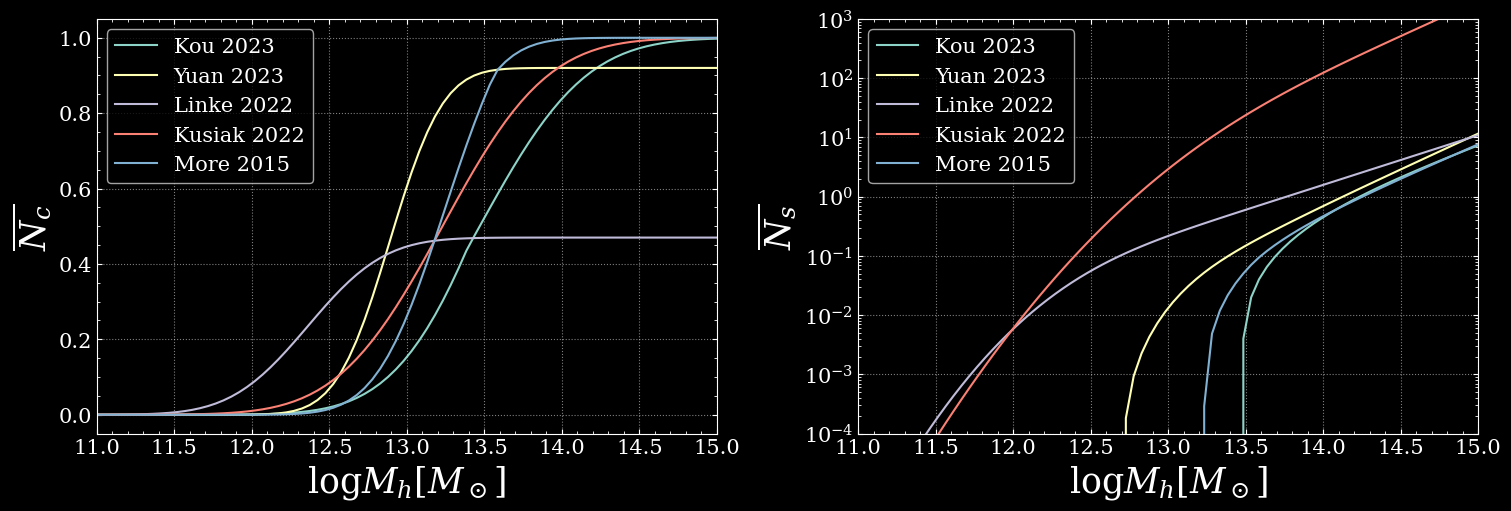

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), layout='constrained')

axs[0].plot(logmhalo, KouNc(), label='Kou 2023')
axs[1].plot(logmhalo, KouNs(), label='Kou 2023')

axs[0].plot(logmhalo, YuanNc(), label='Yuan 2023')
axs[1].plot(logmhalo, YuanNs(), label='Yuan 2023')

axs[0].plot(logmhalo, LinkeNc(), label='Linke 2022')
axs[1].plot(logmhalo, LinkeNs(), label='Linke 2022')

axs[0].plot(logmhalo, KusiakNc(), label='Kusiak 2022')
axs[1].plot(logmhalo, KusiakNs(), label='Kusiak 2022')

axs[0].plot(logmhalo, MoreNc(), label='More 2015')
axs[1].plot(logmhalo, MoreNs(), label='More 2015')

axs[0].set(ylabel=r'$\overline{N_c}$', xlabel=r'log$M_h [M_\odot]$', xlim=(11, 15)); axs[0].legend()
axs[1].set(ylabel=r'$\overline{N_s}$', xlabel=r'log$M_h [M_\odot]$', yscale='log', ylim=(1e-4, 1e3), xlim=(11, 15)); axs[1].legend()

plt.show()

### Satellite Distribution Profiles

You also need profiles which describe the distribution of galaxies around the halo center: centrals are almost always just a dirac delta (1 in Fourier space), and satellites often take the form of an NFW sometimes with a modified parameter.

In [ ]:
cpars = {"hh": 0.7, "Omega_L":0.7, "Omega_m":0.3, "Omega_b": 0.044, "XH": 0.76, "T_CMB":2.725}
logmshalo = np.linspace(10, 14, 50)
zs = np.linspace(0.4, 1.1, 10)
rs = np.logspace(-1.5, 1.5, 100)

cosmology = astropy.cosmology.LambdaCDM(H0=cpars["hh"]*100, Tcmb0=2.726, Om0=cpars["Omega_m"], Ode0=cpars["Omega_L"], Ob0=cpars["Omega_b"])
rhoc = lambda zs: cosmology.critical_density(zs).to(u.Msun/u.Mpc**3).value
r200c = lambda zs, logmshalo: (10**logmshalo/(4/3*np.pi*200*rhoc(zs)[:, None]))**(1/3)

# Precalculate values
rs200c = r200c(zs, logmshalo)

import Models.FFTs as FFTs
fft = FFTs.mcfit_package(rs)
ks, FFT_func = fft.ks, fft.FFT3D

In [19]:
import Models.HODs as HODs

Kou = HODs.Kou2023({'sample':'M*>10.8'})
KouRho = Kou.usk(rs, rs200c, FFT_func)

Yuan = HODs.Yuan2023({'sample':"LRG 0.4<z<0.6"})
YuanRho = Yuan.usk(rs, rs200c, FFT_func)

Linke = HODs.Linke2022({'sample':'MS red'})
LinkeRho = Linke.usk(rs, rs200c, FFT_func)

Kusiak = HODs.Kusiak2022({'sample':'Red'})
KusiakRho = Kusiak.usk(rs, rs200c, FFT_func)

More = HODs.More2015({'sample':'[11.10, 12.00]'})
MoreRho = More.usk(rs, rs200c, FFT_func)

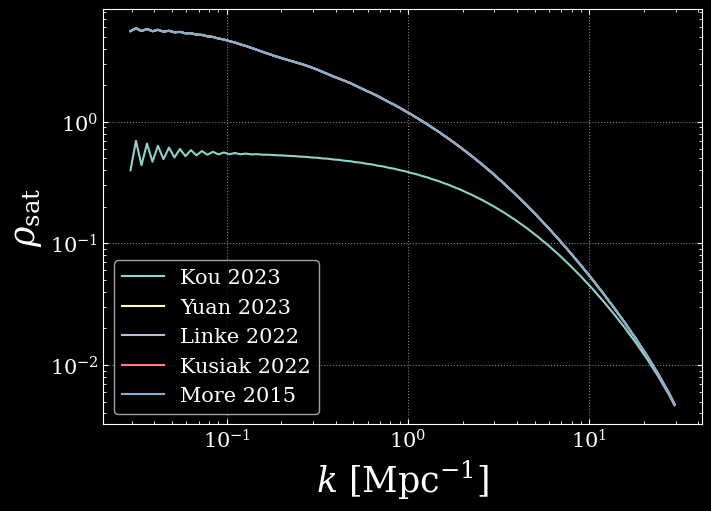

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), layout='constrained')

zindex, mindex = 4, 25

ax.plot(ks, KouRho()[:, zindex, mindex], label='Kou 2023')

ax.plot(ks, YuanRho()[:, zindex, mindex], label='Yuan 2023')

ax.plot(ks, LinkeRho()[:, zindex, mindex], label='Linke 2022')

ax.plot(ks, KusiakRho()[:, zindex, mindex], label='Kusiak 2022')

ax.plot(ks, MoreRho()[:, zindex, mindex], label='More 2015')

ax.set(ylabel=r'$\rho_\text{sat}$', xlabel=r'$k$ [Mpc$^{-1}$]', yscale='log', xscale='log'); ax.legend()

plt.show()

# Halo Models

A Halo Mass Function is necessary for any calculations of the cross-spectra, and the galaxy bias and linear power spectrum are necessary for two-halo calculations.

In [61]:
cpars = {"hh": 0.7, "Omega_L":0.7, "Omega_m":0.3, "Omega_b": 0.044, "XH": 0.76, "T_CMB":2.725}
logmhalo = np.linspace(10, 14, 50)
z = np.linspace(0.4, 1.1, 10)
k = np.logspace(-1, 1)

In [62]:
import Models.HaloModels as HaloModels
importlib.reload(HaloModels)

ccl = HaloModels.pyccl({'mdef':'200c', 'mfunc':'Tinker08', 'hbias':'Tinker10'})
ccl_hmf = ccl.HMF(z, logmhalo, **cpars)
ccl_bh = ccl.bh(z, logmhalo, **cpars)
ccl_Plin = ccl.Plin(k, z, **cpars)

hmfpack = HaloModels.hmf_package({'mfunc':'Tinker08', 'mdef':'SOCritical'}).HMF(z, logmhalo, **cpars)

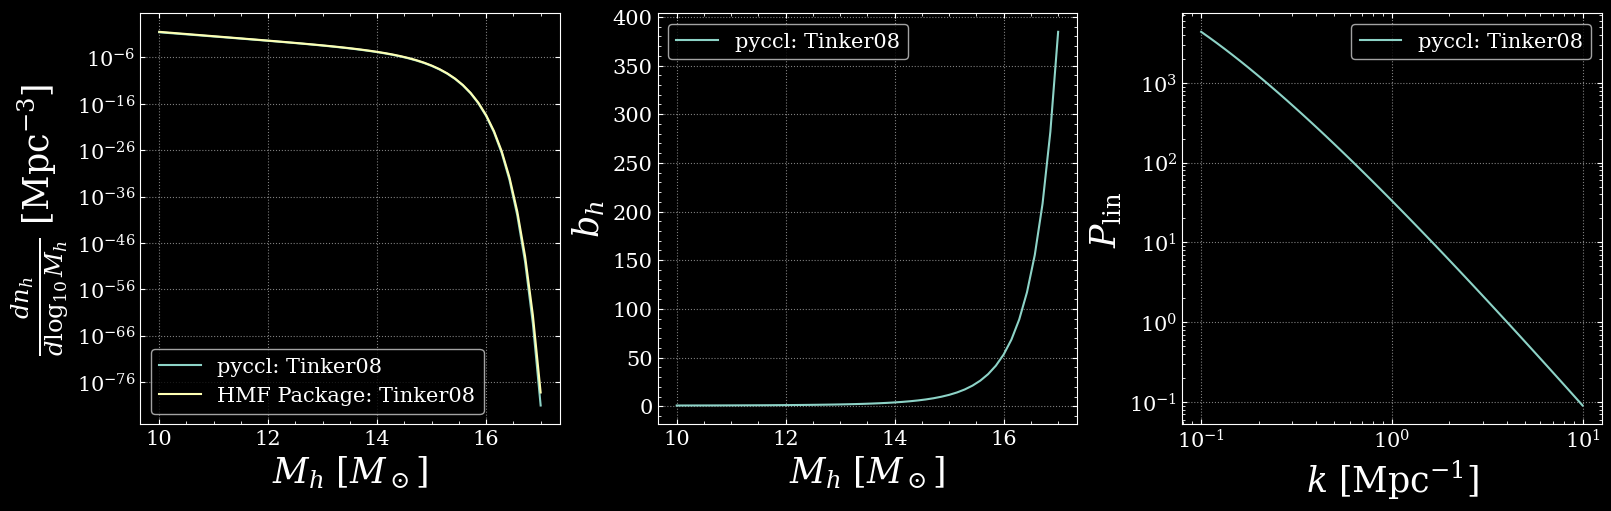

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5), layout='constrained')

zindex = 5
axs[0].plot(logmhalo, ccl_hmf[zindex], label='pyccl: Tinker08')
axs[1].plot(logmhalo, ccl_bh[zindex], label='pyccl: Tinker08')
axs[2].loglog(k, ccl_Plin[:, zindex], label='pyccl: Tinker08')

axs[0].plot(logmhalo, hmfpack[zindex], label='HMF Package: Tinker08')

axs[0].set(ylabel=r'$\frac{dn_h}{d\log_{10} M_h}$ [Mpc$^{-3}$]', xlabel=r'$M_h \ [M_\odot]$', yscale='log'); axs[0].legend()
axs[1].set(ylabel=r'$b_h$', xlabel=r'$M_h \ [M_\odot]$'); axs[1].legend()
axs[2].set(ylabel=r'$P_\text{lin}$', xlabel=r'$k \ [\text{Mpc}^{-1}]$'); axs[2].legend()

plt.show()

# Halo Profiles (two-halo)

The two-halo requires quite a bit of set up, calculated through the same method of calculating cross-spectra.

In [21]:
cpars = {"hh": 0.7, "Omega_L":0.7, "Omega_m":0.3, "Omega_b": 0.044, "XH": 0.76, "T_CMB":2.725}
logmshalo = np.linspace(10, 14, 50)
zs = np.linspace(0.4, 1.1, 10)
rs = np.logspace(-1.5, 1.5, 100)

cosmology = astropy.cosmology.LambdaCDM(H0=cpars["hh"]*100, Tcmb0=2.726, Om0=cpars["Omega_m"], Ode0=cpars["Omega_L"], Ob0=cpars["Omega_b"])
rhoc = lambda zs: cosmology.critical_density(zs).to(u.Msun/u.Mpc**3).value
r200c = lambda zs, logmshalo: (10**logmshalo/(4/3*np.pi*200*rhoc(zs)[:, None]))**(1/3)
rhocs = rhoc(zs)
rs200c = r200c(zs, logmshalo)

import Models.FFTs as FFTs
fft = FFTs.mcfit_package(rs)
ks, FFT_func = fft.ks, fft.FFT3D
rs_rev, IFFT_func = fft.rs_rev, fft.IFFT3D

import Models.HaloModels as HaloModels
hmfccl = HaloModels.pyccl({'mdef':'200c', 'mfunc':'Tinker08', 'hbias':'Tinker10'})
Pklin = hmfccl.Plin(ks, zs, **cpars)
bias = hmfccl.bh(zs, logmshalo, **cpars)
hmf = hmfccl.HMF(zs, logmshalo, **cpars)

In [22]:
import Models.Profiles as Profiles

Amodeo = Profiles.Amodeo2021({'model':'GNFW'})

AmodeoPth_1h = Amodeo.Pth1h(rs, zs, logmshalo, rhocs, rs200c, **cpars)
AmodeoPth_2h = Amodeo.Pth2h(rs, zs, logmshalo, rhocs, rs200c, Pklin, bias, hmf, FFT_func, IFFT_func, ks, **cpars)
AmodeoPth = lambda p={}: AmodeoPth_1h(p)+AmodeoPth_2h(p)[..., None]

Amodeorho_1h = Amodeo.rho1h(rs, zs, logmshalo, rhocs, rs200c, **cpars)
Amodeorho_2h = Amodeo.rho2h(rs, zs, logmshalo, rhocs, rs200c, Pklin, bias, hmf, FFT_func, IFFT_func, ks, **cpars)
Amodeorho = lambda p={}: Amodeorho_1h(p)+Amodeorho_2h(p)[..., None]

BattagliaPth = Profiles.Battaglia2012({'model':'B12'})
BattagliaPth_1h = Battaglia12.Pth1h(rs, zs, logmshalo, rhocs, rs200c, **cpars)
BattagliaPth_2h = Battaglia12.Pth2h(rs, zs, logmshalo, rhocs, rs200c, Pklin, bias, hmf, FFT_func, IFFT_func, **cpars)
BattagliaPth = lambda p={}: BattagliaPth_1h(p)+BattagliaPth_2h(p)

Battagliarho = Profiles.Battaglia2015({'model':'AGN'})
Battagliarho_1h = Battaglia15.rho1h(rs, zs, logmshalo, rhocs, rs200c, **cpars)
Battagliarho_2h = Battaglia15.rho2h(rs, zs, logmshalo, rhocs, rs200c, Pklin, bias, hmf, FFT_func, IFFT_func, **cpars)
Battagliarho = lambda p={}: Battagliarho_1h(p)+Battagliarho_2h(p)

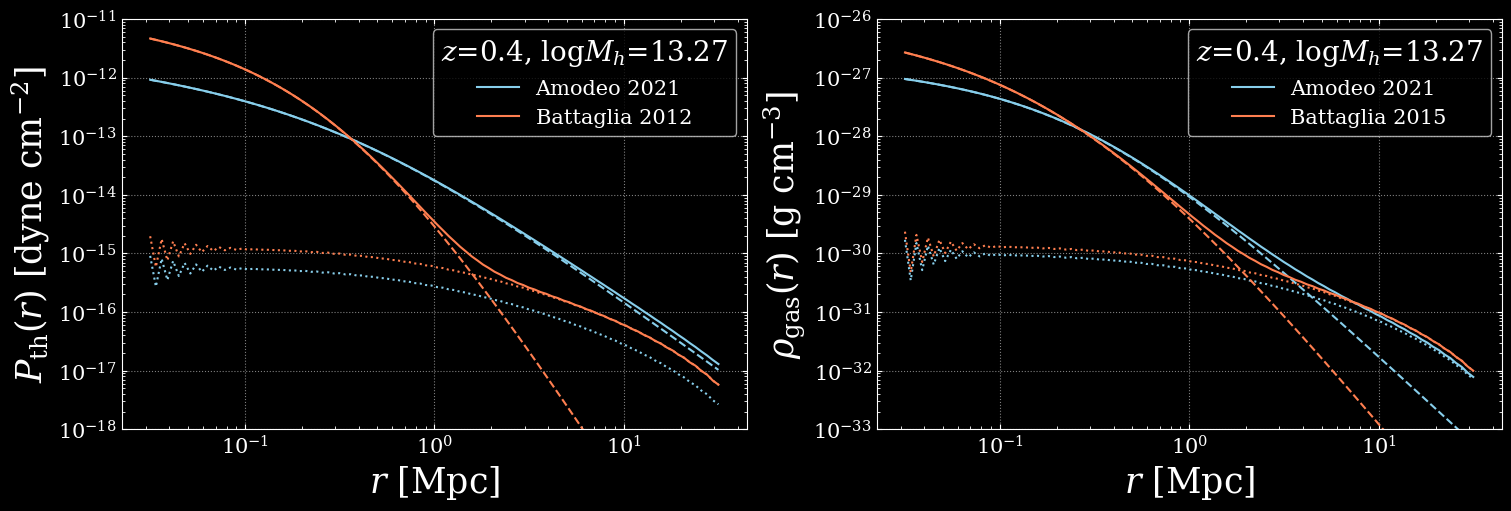

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), layout='constrained')

zindex, mindex = 0, 40

axs[0].loglog(rs, AmodeoPth()[:, zindex, mindex], label='Amodeo 2021', c='skyblue')
axs[0].loglog(rs, AmodeoPth_1h()[:, zindex, mindex], ls='--', c='skyblue')
axs[0].loglog(rs, AmodeoPth_2h()[:, zindex], c='skyblue', ls=':')

axs[1].loglog(rs, Amodeorho()[:, zindex, mindex], label='Amodeo 2021', c='skyblue')
axs[1].loglog(rs, Amodeorho_1h()[:, zindex, mindex], c='skyblue', ls='--')
axs[1].loglog(rs, Amodeorho_2h()[:, zindex], c='skyblue', ls=':')

axs[0].loglog(rs, BattagliaPth()[:, zindex, mindex], label='Battaglia 2012', c='coral')
axs[0].loglog(rs, BattagliaPth_1h()[:, zindex, mindex], ls='--', c='coral')
axs[0].loglog(rs, BattagliaPth_2h()[:, zindex, mindex], ls=':', c='coral')

axs[1].loglog(rs, Battagliarho()[:, zindex, mindex], label='Battaglia 2015', c='coral')
axs[1].loglog(rs, Battagliarho_1h()[:, zindex, mindex], ls='--', c='coral')
axs[1].loglog(rs, Battagliarho_2h()[:, zindex, mindex], ls=':', c='coral')

axs[0].set(ylabel=r'$P_\text{th}(r)$ [dyne cm$^{-2}$]', xlabel=r'$r$ [Mpc]', ylim=(1e-18, 1e-11)); axs[0].legend(title=f'$z$={zs[zindex]}, log$M_h$={logmshalo[40]:.2f}')
axs[1].set(ylabel=r'$\rho_\text{gas}(r)$ [g cm$^{-3}]$', xlabel=r'$r$ [Mpc]', ylim=(1e-33, 1e-26)); axs[1].legend(title=f'$z$={zs[zindex]}, log$M_h$={logmshalo[40]:.2f}')

plt.show()

# Dust Profiles

tSZ needs a dust profile to account for contamination.

In [24]:
thetas = np.linspace(0, 6, 10)
freq = 150

In [25]:
import Models.Dust as Dust

AmodeoDust = Dust.Amodeo2021({'model':'ACT+Hershel'})
AmodeoDust_poly = AmodeoDust.dustpoly(thetas, freq)
AmodeoDust_uK = AmodeoDust.dust_uKarcmin(thetas, freq)

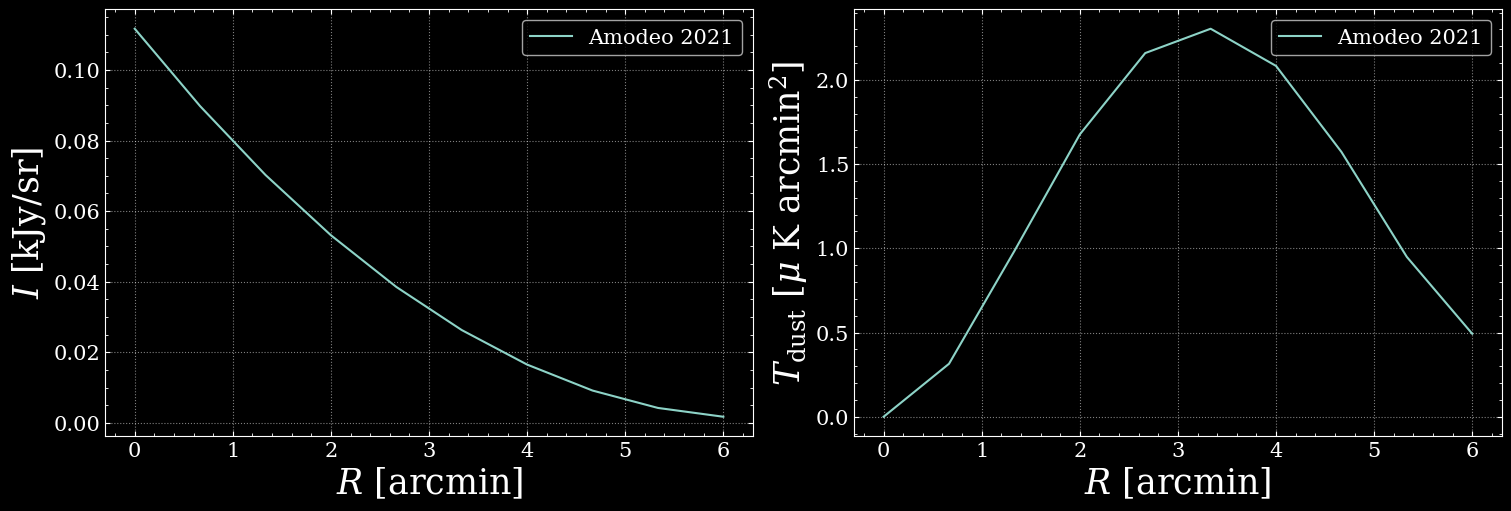

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), layout='constrained')

axs[0].plot(thetas, AmodeoDust_poly(), label='Amodeo 2021')
axs[1].plot(thetas, AmodeoDust_uK(), label='Amodeo 2021')

axs[0].set(xlabel=r'$R$ [arcmin]', ylabel=r'$I$ [kJy/sr]'); axs[0].legend()
axs[1].set(xlabel=r'$R$ [arcmin]', ylabel=r'$T_\text{dust}$ [$\mu$ K arcmin$^2$]'); axs[1].legend()

plt.show()

# Data

tSZ and kSZ measurements and results for simulations are also collected here.

In [27]:
cpars = {"hh": 0.7, "Omega_L":0.7, "Omega_m":0.3, "Omega_b": 0.044, "XH": 0.76, "T_CMB":2.725}

def fnu(nu):
    x = (c.h * nu*u.GHz / (c.k_B * cpars['T_CMB']*u.K)).decompose().value
    ans = x / np.tanh(x / 2.0) - 4.0
    return ans

touK = lambda nu: fnu(nu)*cpars['T_CMB']*1e6

In [ ]:
import Models.Data as Data
importlib.reload(Data)

Liu2025 = Data.Liu2025({'zbin':'1', 'Beta':'1.2', 'TCIB':'10.7', 'dp':'dBeta', 'DR':'DR6'})
Liu2025DR5 = Data.Liu2025({'zbin':'1', 'DR':'DR5', 'freq':'150', 'aper':'CAP'})

Hadzhiyska2025 = Data.Hadzhiyska2025({'zbin':'1', 'sample':'main', 'corr':'uncorrected', 'zoutcut':'nocut'})

Guachalla2025 = Data.RiedGuachalla2025({'zbin':'all', 'mbin':'all'})

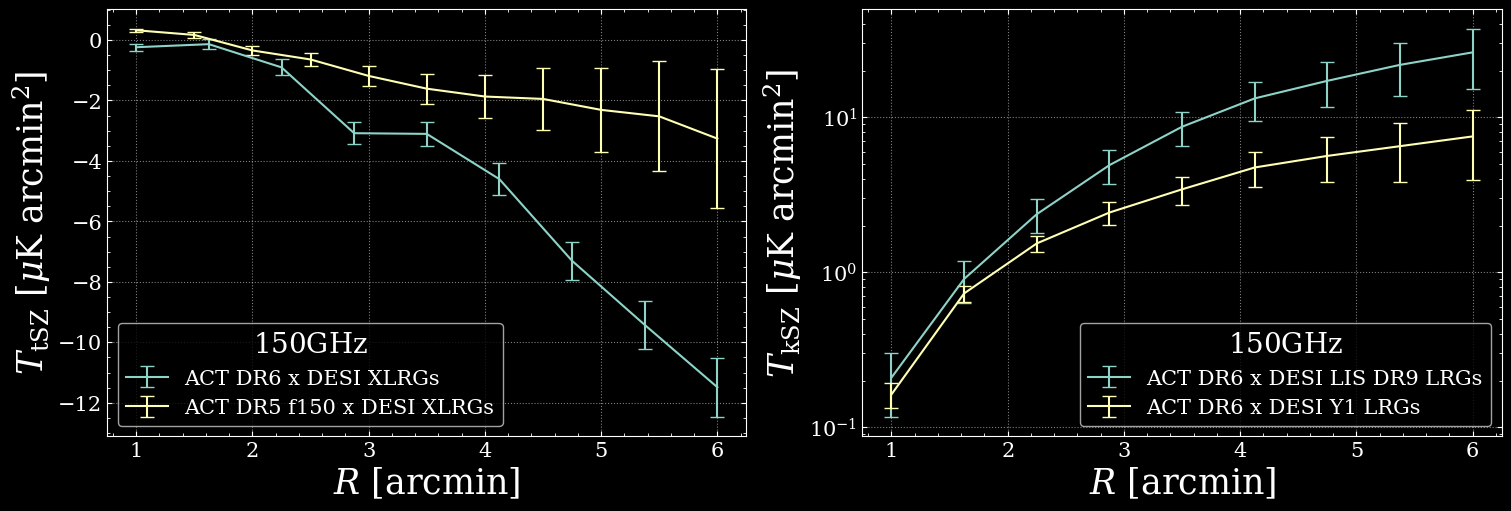

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), layout='constrained')

axs[0].errorbar(Liu2025.thetas, Liu2025.tSZdata*touK(150), -Liu2025.tSZerr*touK(150), capsize=5, label='ACT DR6 x DESI XLRGs')
axs[0].errorbar(Liu2025DR5.thetas, Liu2025DR5.tSZdata*touK(150), -Liu2025DR5.tSZerr*touK(150), capsize=5, label='ACT DR5 f150 x DESI XLRGs')

axs[1].errorbar(Hadzhiyska2025.thetas, Hadzhiyska2025.kSZdata, Hadzhiyska2025.kSZerr, capsize=5, label='ACT DR6 x DESI LIS DR9 LRGs')

axs[1].errorbar(Guachalla2025.thetas, Guachalla2025.kSZdata, Guachalla2025.kSZerr, capsize=5, label='ACT DR6 x DESI Y1 LRGs')

# # This part won't work without Manu's data
# Schaan2021 = Data.Schaan2021({'freq': '150', 'sample':'cmass'})
# axs[0].errorbar(Schaan2021.thetas, Schaan2021.tSZdata, Schaan2021.tSZerr, capsize=5, label='ACT DR5 x CMASS DR10')
# axs[1].errorbar(Schaan2021.thetas, Schaan2021.kSZdata, Schaan2021.kSZerr, capsize=5, label='ACT DR5 x CMASS DR10')

axs[0].set(xlabel=r'$R$ [arcmin]', ylabel=r'$T_\text{tSZ}$ [$\mu$K arcmin$^2$]'); axs[0].legend(title=r'$150$GHz')
axs[1].set(xlabel=r'$R$ [arcmin]', ylabel=r'$T_\text{kSZ}$ [$\mu$K arcmin$^2$]', yscale='log'); axs[1].legend(title=r'$150$GHz', loc='lower right')
plt.show()